In [4]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else self.n_features
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feat_idx = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_threshold = self._best_split(X, y, feat_idx)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None


        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])

        child_entropy = (n_l / n)*e_l + (n_r / n)*e_r

        return parent_entropy - child_entropy

    def _split(self, X_column, threshold):
        left_idx = np.argwhere(X_column <= threshold).flatten()
        right_idx = np.argwhere(X_column > threshold).flatten()
        return left_idx, right_idx

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)

        return -sum(p*np.log(p) for p in ps if p > 0)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

Accuracy: 0.9385964912280702
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        46
           1       0.96      0.94      0.95        68

    accuracy                           0.94       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114



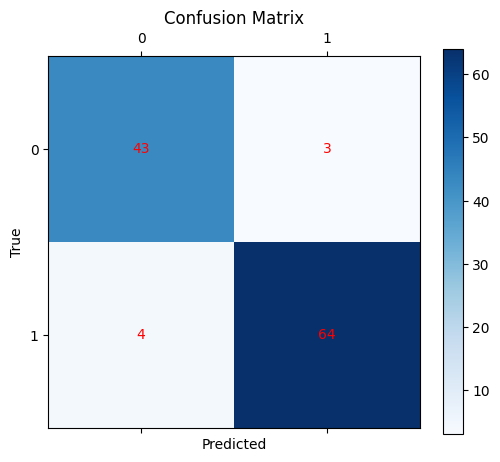

In [6]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

clf = DecisionTree()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center', color='red')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()
